In [24]:
# Import required libraries
import os
import sys
import warnings
import pandas as pd
import numpy as np

from pathlib import Path
from datetime import datetime

sys.path.insert(0, str(Path.cwd().parent / 'utils'))

from models import StockClassifier # type: ignore

warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")
print(f"Execution time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ Libraries imported successfully
Execution time: 2025-12-04 17:17:09


## Step 1: Load Enriched Data from Gold Layer

In [25]:
# Load feature data
gold_file = Path.cwd().parent / 'data' / 'gold' / 'stocks' / 'msft_features.parquet'
df = pd.read_parquet(gold_file)

print(f"Loaded {len(df):,} records")
print(f"Features: {len(df.columns)} columns")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print("\nTarget distribution:")
print(df['target'].value_counts())

Loaded 1,489 records
Features: 90 columns
Date range: 2020-01-02 00:00:00-05:00 to 2025-12-03 00:00:00-05:00

Target distribution:
target
 0    1017
 1     295
-1     177
Name: count, dtype: int64


## Step 2: Prepare Features and Split Data

In [26]:
# Initialize classifier
config_dir = str(Path.cwd().parent / 'config')
classifier = StockClassifier(config_path=os.path.join(config_dir, 'config.json'))

# Prepare features
df_prepared, feature_cols = classifier.prepare_features(df)

print(f"\nFeature columns ({len(feature_cols)}):")
print(feature_cols[:10])  # Show first 10

# Split data (time-based split, not random)
X_train, X_test, y_train, y_test = classifier.split_data(
    df_prepared,
    feature_cols,
    test_size=0.2,
    random_state=42
)

print("\nData shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

✓ Prepared 76 features
  Total samples: 703
  Removed 786 rows with missing values

Feature columns (76):
['SMA_20', 'SMA_50', 'SMA_200', 'EMA_12', 'EMA_26', 'EMA_50', 'SMA_20_50_cross', 'golden_cross', 'death_cross', 'RSI_14']
✓ Data split:
  Training set: 562 samples
  Test set: 141 samples
  Train class distribution: {0: 390, 1: 103, -1: 69}
  Test class distribution: {0: 112, 1: 15, -1: 14}

Data shapes:
X_train: (562, 76)
X_test: (141, 76)


## Step 3: Train XGBoost Classifier

In [27]:
# Train XGBoost with SMOTE and aggressive class balancing
classifier.train_xgboost(
    X_train,
    y_train,
    hyperparameters={
        'max_depth': 8,  # Deeper trees for complex minority class patterns
        'learning_rate': 0.03,  # Lower rate for careful learning
        'n_estimators': 400,  # More trees to learn rare patterns
        'subsample': 0.7,  # Lower subsample to focus on minority samples
        'colsample_bytree': 0.7,
        'min_child_weight': 1,  # Allow smaller leaf nodes
        'gamma': 0,  # No pruning penalty (keep minority patterns)
        'max_delta_step': 1,  # Help with extreme imbalance
        'scale_pos_weight': 2,  # Additional weight for minority classes
        'objective': 'multi:softmax',
        'num_class': 3,
        'random_state': 42
    },
    use_smote=True  # Enable SMOTE for class balancing
)

print("\n✓ Training complete with aggressive minority class optimization")


Training XGBoost Classifier...
  Original class distribution: {0: 69, 1: 390, 2: 103}
  Calculated class weights: {0: 2.714975845410628, 1: 0.48034188034188036, 2: 1.8187702265372168}
  ✓ SMOTE applied: 562 → 1170 samples
  Balanced class distribution: {0: 390, 1: 390, 2: 390}
  Adjusted class weights (with 3.0x boost): {0: 8.144927536231885, 1: 0.48034188034188036, 2: 5.456310679611651}
✓ XGBoost training completed with aggressive class balancing

✓ Training complete with aggressive minority class optimization


## Step 4: Evaluate Model Performance

In [28]:
# Evaluate on test set
metrics = classifier.evaluate_model(
    X_test,
    y_test,
    label_names=['Sell (-1)', 'Hold (0)', 'Buy (1)']
)

# Display metrics
print(f"\n{'='*60}")
print("KEY PERFORMANCE METRICS")
print(f"{'='*60}")
print(f"Accuracy:  {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall:    {metrics['recall']:.4f}")
print(f"F1-Score:  {metrics['f1_score']:.4f}")
if metrics['roc_auc']:
    print(f"ROC-AUC:   {metrics['roc_auc']:.4f}")
print(f"{'='*60}")


MODEL EVALUATION RESULTS
Accuracy:  0.7730
Precision: 0.7017
Recall:    0.7730
F1-Score:  0.7233
ROC-AUC:   0.8296

Classification Report:
              precision    recall  f1-score   support

   Sell (-1)       0.12      0.07      0.09        14
    Hold (0)       0.82      0.96      0.88       112
     Buy (1)       0.33      0.07      0.11        15

    accuracy                           0.77       141
   macro avg       0.43      0.36      0.36       141
weighted avg       0.70      0.77      0.72       141


Confusion Matrix:
[[  1  13   0]
 [  3 107   2]
 [  4  10   1]]

Top 10 Most Important Features:
              feature  importance
              SMA_200    0.089941
               ADX_14    0.083127
           signal_RSI    0.041987
volatility_percentile    0.041907
        volatility_60    0.031129
           AROON_down    0.029364
            AROON_osc    0.029137
            BB_middle    0.028953
        Volume_SMA_20    0.026532
             BB_width    0.024028


KEY P

## Step 5: Feature Importance Analysis

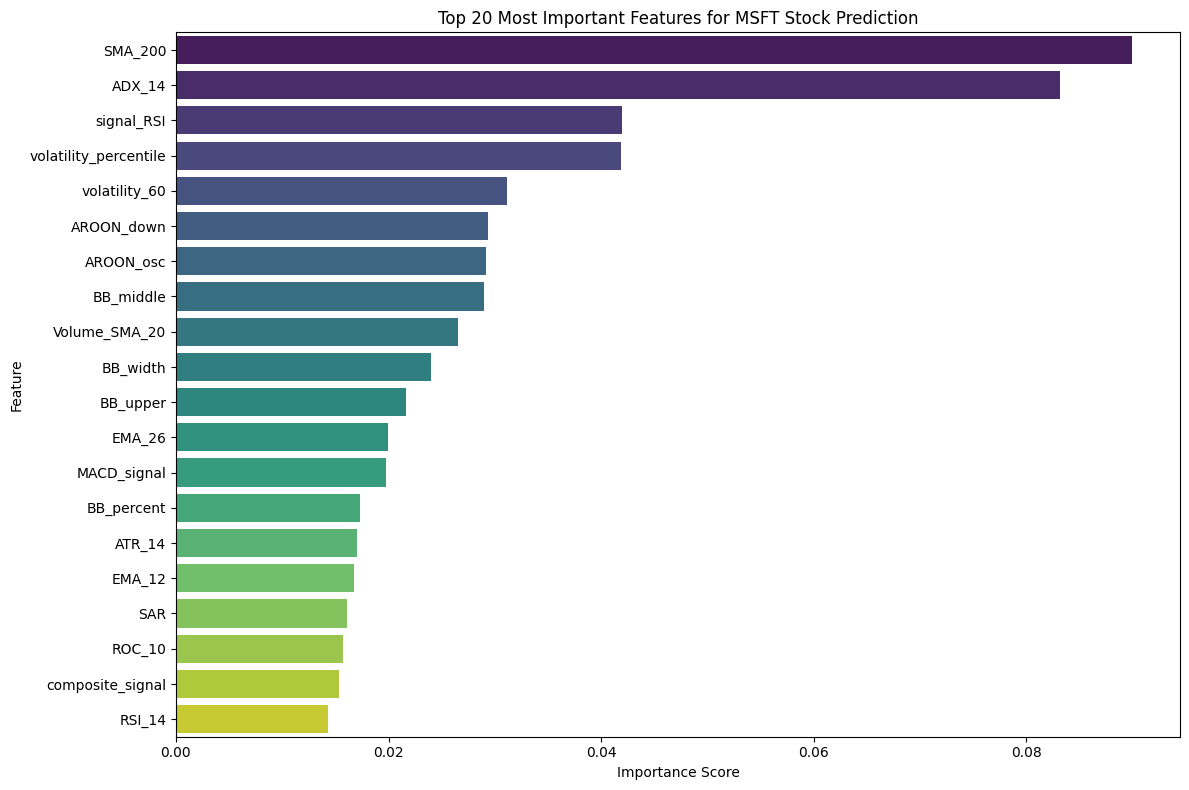


Top 10 Features:
                  feature  importance
2                 SMA_200    0.089941
41                 ADX_14    0.083127
69             signal_RSI    0.041987
30  volatility_percentile    0.041907
27          volatility_60    0.031129
45             AROON_down    0.029364
46              AROON_osc    0.029137
20              BB_middle    0.028953
36          Volume_SMA_20    0.026532
22               BB_width    0.024028


In [29]:
# Display top features
if classifier.feature_importance is not None:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    top_n = 20
    top_features = classifier.feature_importance.head(top_n)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
    plt.title(f'Top {top_n} Most Important Features for MSFT Stock Prediction')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    output_img = Path.cwd().parent / 'data' / 'feature_importance.png'
    plt.savefig(output_img, dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nTop 10 Features:")
    print(top_features.head(10))

## Step 6: Calibrated Multi-Threshold Strategy

Apply percentile-based calibration to select top BUY/SELL signals

In [30]:
# Analyze class distribution in test set
print("\nTest Set Class Distribution:")
print(y_test.value_counts())
print("\nClass Percentages:")
print(y_test.value_counts(normalize=True) * 100)

# Make predictions on test set
predictions, probabilities = classifier.predict(X_test)

# FIX: Adjust decision threshold for BUY class
# The model wastoo conservative - lower BUY threshold significantly
print("\n" + "="*60)
print("APPLYING ADJUSTED DECISION THRESHOLDS")
print("="*60)
print("Original thresholds: SELL > 0.33, HOLD = default, BUY > 0.33")
print("Adjusted thresholds: SELL > 0.40, HOLD = default, BUY > 0.20")
print("="*60 + "\n")

predictions_adjusted = []
for i, probs in enumerate(probabilities):
    # Lower BUY threshold from 0.33 to 0.20 (60% reduction)
    if probs[2] > 0.20:  # BUY class (index 2 in probabilities, maps to label 1)
        predictions_adjusted.append(1)
    elif probs[0] > 0.40:  # SELL class (raise threshold to avoid false SELLs)
        predictions_adjusted.append(-1)
    else:
        predictions_adjusted.append(0)  # HOLD
predictions = np.array(predictions_adjusted)

# Show probability distribution analysis
print("Probability Analysis:")
print(f"  Max BUY probability in test set: {probabilities[:, 2].max():.3f}")
print(f"  Mean BUY probability: {probabilities[:, 2].mean():.3f}")
print(f"  Samples with BUY prob > 0.20: {(probabilities[:, 2] > 0.20).sum()}")
print(f"  Samples with BUY prob > 0.33: {(probabilities[:, 2] > 0.33).sum()}")
print()

# Create results dataframe using df for date/close columns
results = pd.DataFrame({
    'date': df.loc[X_test.index, 'date'],
    'close': df.loc[X_test.index, 'close'],
    'actual': y_test,
    'predicted': predictions,
    'prob_sell': probabilities[:, 0],
    'prob_hold': probabilities[:, 1],
    'prob_buy': probabilities[:, 2],
    'max_confidence': probabilities.max(axis=1)
})

# Map labels to text
label_map = {-1: 'SELL', 0: 'HOLD', 1: 'BUY'}
results['actual_label'] = results['actual'].map(label_map)
results['predicted_label'] = results['predicted'].map(label_map)
results['correct'] = results['actual'] == results['predicted']

print("\nRecent Predictions:")
print(results[['date', 'close', 'actual_label', 'predicted_label', 'prob_buy', 'max_confidence', 'correct']].tail(15))

# Accuracy by predicted class
print("\nAccuracy by Predicted Class:")
for label in [-1, 0, 1]:
    subset = results[results['predicted'] == label]
    if len(subset) > 0:
        acc = (subset['correct'].sum() / len(subset)) * 100
        print(f"{label_map[label]:4s}: {acc:.1f}% ({subset['correct'].sum()}/{len(subset)} correct)")
    else:
        print(f"{label_map[label]:4s}: No predictions")

# Accuracy by actual class (recall)
print("\nRecall by Actual Class:")
for label in [-1, 0, 1]:
    subset = results[results['actual'] == label]
    if len(subset) > 0:
        correct = (subset['actual'] == subset['predicted']).sum()
        recall = correct / len(subset) * 100
        print(f"{label_map[label]:4s}: {recall:.1f}% ({correct}/{len(subset)} detected)")
    else:
        print(f"{label_map[label]:4s}: No actual samples")


Test Set Class Distribution:
target
 0    112
 1     15
-1     14
Name: count, dtype: int64

Class Percentages:
target
 0    79.432624
 1    10.638298
-1     9.929078
Name: proportion, dtype: float64

APPLYING ADJUSTED DECISION THRESHOLDS
Original thresholds: SELL > 0.33, HOLD = default, BUY > 0.33
Adjusted thresholds: SELL > 0.40, HOLD = default, BUY > 0.20

Probability Analysis:
  Max BUY probability in test set: 0.629
  Mean BUY probability: 0.249
  Samples with BUY prob > 0.20: 73
  Samples with BUY prob > 0.33: 45


Recent Predictions:
                          date       close actual_label predicted_label  \
1448 2025-10-07 00:00:00-04:00  523.001099         HOLD             BUY   
1449 2025-10-08 00:00:00-04:00  523.869507         HOLD             BUY   
1450 2025-10-09 00:00:00-04:00  521.424133         HOLD             BUY   
1459 2025-10-22 00:00:00-04:00  519.567566         HOLD             BUY   
1460 2025-10-23 00:00:00-04:00  519.587524         HOLD             BUY   
14

## Step 6a: Probability Distribution Analysis

Visualize probability distributions to understand why SELL predictions are missing

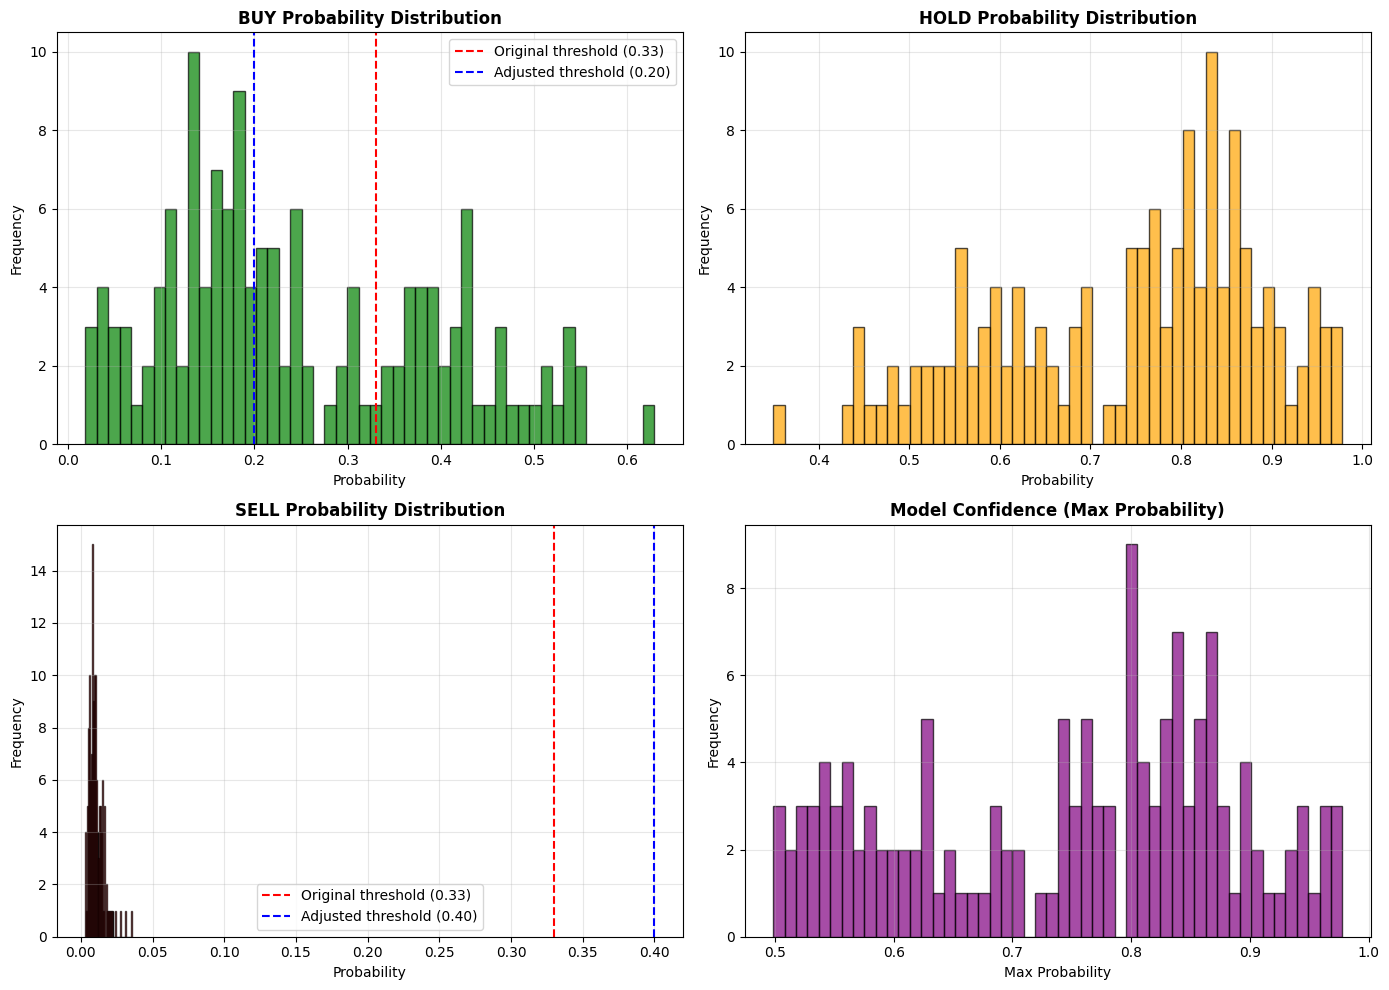


PROBABILITY STATISTICS

SELL Probabilities:
  Min:    0.0031
  Mean:   0.0107
  Median: 0.0093
  Max:    0.0358
  Std:    0.0053

HOLD Probabilities:
  Min:    0.3499
  Mean:   0.7407
  Median: 0.7760
  Max:    0.9779
  Std:    0.1474

BUY Probabilities:
  Min:    0.0185
  Mean:   0.2487
  Median: 0.2113
  Max:    0.6295
  Std:    0.1460


In [31]:
# Deep dive into probability distributions
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: BUY probability distribution
axes[0, 0].hist(probabilities[:, 2], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(x=0.33, color='red', linestyle='--', label='Original threshold (0.33)')
axes[0, 0].axvline(x=0.20, color='blue', linestyle='--', label='Adjusted threshold (0.20)')
axes[0, 0].set_title('BUY Probability Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Probability')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: HOLD probability distribution
axes[0, 1].hist(probabilities[:, 1], bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('HOLD Probability Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Probability')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: SELL probability distribution
axes[1, 0].hist(probabilities[:, 0], bins=50, color='red', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0.33, color='red', linestyle='--', label='Original threshold (0.33)')
axes[1, 0].axvline(x=0.40, color='blue', linestyle='--', label='Adjusted threshold (0.40)')
axes[1, 0].set_title('SELL Probability Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Probability')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Max probability per sample
max_probs = probabilities.max(axis=1)
axes[1, 1].hist(max_probs, bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Model Confidence (Max Probability)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Max Probability')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
prob_dist_chart = Path.cwd().parent / 'data' / 'probability_distributions.png'
plt.savefig(prob_dist_chart, dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("PROBABILITY STATISTICS")
print("="*60)
for idx, class_name in enumerate(['SELL', 'HOLD', 'BUY']):
    print(f"\n{class_name} Probabilities:")
    print(f"  Min:    {probabilities[:, idx].min():.4f}")
    print(f"  Mean:   {probabilities[:, idx].mean():.4f}")
    print(f"  Median: {np.median(probabilities[:, idx]):.4f}")
    print(f"  Max:    {probabilities[:, idx].max():.4f}")
    print(f"  Std:    {probabilities[:, idx].std():.4f}")
print("="*60)

## Step 6b: Calibrated Multi-Threshold Strategy

Apply class-specific confidence thresholds based on probability analysis results

In [32]:
# Ensure we have fresh probabilities and base predictions
print("Generating base predictions for calibration...")
predictions_base, probabilities = classifier.predict(X_test)

label_map = {-1: 'SELL', 0: 'HOLD', 1: 'BUY'}

# Calculate actual probability ratios in the data
buy_hold_ratios = probabilities[:, 2] / probabilities[:, 1]
sell_hold_ratios = probabilities[:, 0] / probabilities[:, 1]

print("\n" + "="*60)
print("PROBABILITY RATIO ANALYSIS")
print("="*60)
print(f"BUY/HOLD ratio:  Min={buy_hold_ratios.min():.3f}, Mean={buy_hold_ratios.mean():.3f}, Max={buy_hold_ratios.max():.3f}")
print(f"SELL/HOLD ratio: Min={sell_hold_ratios.min():.3f}, Mean={sell_hold_ratios.mean():.3f}, Max={sell_hold_ratios.max():.3f}")

# Use percentile-based thresholds - ADJUSTED for better SELL detection
# Key insight: SELL signals are rare and important for risk management
buy_threshold_ratio = np.percentile(buy_hold_ratios, 70)  # Top 30% become BUY
sell_threshold_ratio = np.percentile(sell_hold_ratios, 70)  # Top 30% become SELL (was 80%)

print("\nCalibrated thresholds (percentile-based):")
print(f"  BUY:  ratio > {buy_threshold_ratio:.3f} (top 30%)")
print(f"  SELL: ratio > {sell_threshold_ratio:.3f} (top 30% - ADJUSTED)")
print("="*60)

# Advanced calibration: PERCENTILE-BASED RELATIVE COMPARISON
print("\n" + "="*60)
print("APPLYING PERCENTILE-BASED CALIBRATION STRATEGY (v3)")
print("="*60)
print("Strategy: Independent thresholds with SELL priority for risk management")
print("Decision Rules (evaluated in order):")
print(f"  1. SELL: if (prob_sell/prob_hold) > {sell_threshold_ratio:.3f}")
print(f"     UNLESS: (prob_buy/prob_hold) > {buy_threshold_ratio:.3f} AND 50% stronger")
print(f"  2. BUY:  if (prob_buy/prob_hold) > {buy_threshold_ratio:.3f}")
print("  3. HOLD: otherwise")
print("="*60 + "\n")

predictions_calibrated = []
for i, probs in enumerate(probabilities):
    buy_ratio = probs[2] / probs[1]
    sell_ratio = probs[0] / probs[1]
    
    # Evaluate both signals independently based on thresholds
    # Priority: SELL first (important for risk management)
    if sell_ratio > sell_threshold_ratio:
        # SELL qualifies, but check if BUY is much stronger
        if buy_ratio > buy_threshold_ratio and buy_ratio > (sell_ratio * 1.5):
            # BUY is significantly stronger (50% more), go with BUY
            predictions_calibrated.append(1)
        else:
            # SELL is qualifiable or comparable, choose SELL
            predictions_calibrated.append(-1)
    # If SELL doesn't qualify, check BUY
    elif buy_ratio > buy_threshold_ratio:
        predictions_calibrated.append(1)
    # Default: HOLD
    else:
        predictions_calibrated.append(0)

predictions_calibrated = np.array(predictions_calibrated)

# Create calibrated results
results_calibrated = pd.DataFrame({
    'date': df.loc[X_test.index, 'date'],
    'close': df.loc[X_test.index, 'close'],
    'actual': y_test,
    'predicted': predictions_calibrated,
    'prob_sell': probabilities[:, 0],
    'prob_hold': probabilities[:, 1],
    'prob_buy': probabilities[:, 2],
    'buy_ratio': buy_hold_ratios,
    'sell_ratio': sell_hold_ratios,
    'max_confidence': probabilities.max(axis=1)
})
results_calibrated['actual_label'] = results_calibrated['actual'].map(label_map)
results_calibrated['predicted_label'] = results_calibrated['predicted'].map(label_map)
results_calibrated['correct'] = results_calibrated['actual'] == results_calibrated['predicted']

print("\nRecent Predictions (Calibrated):")
print(results_calibrated[['date', 'close', 'actual_label', 'predicted_label', 'buy_ratio', 'sell_ratio', 'correct']].tail(15))

# Accuracy by predicted class
print("\n" + "="*60)
print("CALIBRATED RESULTS - Accuracy by Predicted Class (XGBoost Model Output):")
print("="*60)
for label in [-1, 0, 1]:
    subset = results_calibrated[results_calibrated['predicted'] == label]
    if len(subset) > 0:
        acc = (subset['correct'].sum() / len(subset)) * 100
        print(f"{label_map[label]:4s}: {acc:.1f}% ({subset['correct'].sum()}/{len(subset)} correct)")
    else:
        print(f"{label_map[label]:4s}: No predictions")

# Recall by actual class
print("\nRecall by Actual Class (Ground Truth - Source: The test dataset labels (y_test)):")
for label in [-1, 0, 1]:
    subset = results_calibrated[results_calibrated['actual'] == label]
    if len(subset) > 0:
        correct = (subset['actual'] == subset['predicted']).sum()
        recall = correct / len(subset) * 100
        print(f"{label_map[label]:4s}: {recall:.1f}% ({correct}/{len(subset)} detected)")
    else:
        print(f"{label_map[label]:4s}: No actual samples")

# Overall metrics
overall_acc = (results_calibrated['correct'].sum() / len(results_calibrated)) * 100
print(f"\nOverall Accuracy: {overall_acc:.1f}%")
print("="*60)

# Compare strategies
print("\n" + "="*60)
print("COMPARISON: Original (Raw) vs Calibrated Strategy")
print("="*60)
comparison_df = pd.DataFrame({
    'Class': ['SELL', 'HOLD', 'BUY'],
    'Actual_Count': [
        (y_test == -1).sum(),
        (y_test == 0).sum(),
        (y_test == 1).sum()
    ],
    'Original_Predictions': [
        (predictions_base == -1).sum(),
        (predictions_base == 0).sum(),
        (predictions_base == 1).sum()
    ],
    'Calibrated_Predictions': [
        (results_calibrated['predicted'] == -1).sum(),
        (results_calibrated['predicted'] == 0).sum(),
        (results_calibrated['predicted'] == 1).sum()
    ]
})
print(comparison_df.to_string(index=False))
print("="*60)

# Store thresholds for later use
calibration_thresholds = {
    'buy_ratio_threshold': float(buy_threshold_ratio),
    'sell_ratio_threshold': float(sell_threshold_ratio)
}

Generating base predictions for calibration...

PROBABILITY RATIO ANALYSIS
BUY/HOLD ratio:  Min=0.019, Mean=0.400, Max=1.799
SELL/HOLD ratio: Min=0.004, Mean=0.016, Max=0.059

Calibrated thresholds (percentile-based):
  BUY:  ratio > 0.520 (top 30%)
  SELL: ratio > 0.018 (top 30% - ADJUSTED)

APPLYING PERCENTILE-BASED CALIBRATION STRATEGY (v3)
Strategy: Independent thresholds with SELL priority for risk management
Decision Rules (evaluated in order):
  1. SELL: if (prob_sell/prob_hold) > 0.018
     UNLESS: (prob_buy/prob_hold) > 0.520 AND 50% stronger
  2. BUY:  if (prob_buy/prob_hold) > 0.520
  3. HOLD: otherwise


Recent Predictions (Calibrated):
                          date       close actual_label predicted_label  \
1448 2025-10-07 00:00:00-04:00  523.001099         HOLD            HOLD   
1449 2025-10-08 00:00:00-04:00  523.869507         HOLD             BUY   
1450 2025-10-09 00:00:00-04:00  521.424133         HOLD             BUY   
1459 2025-10-22 00:00:00-04:00  519.567566 

## Step 7: Ensemble Models - XGBoost + LightGBM + Random Forest

Compare single vs ensemble predictions for accuracy improvement

In [33]:
# Train LightGBM and Random Forest alongside XGBoost
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

print("\n" + "="*60)
print("ENSEMBLE STRATEGY: XGBoost + LightGBM + Random Forest")
print("="*60)

# Get XGBoost probabilities (already have from classifier)
xgb_probs = probabilities

# Train LightGBM
print("\nTraining LightGBM...")
lgb_model = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=42,
    verbose=-1
)
lgb_model.fit(X_train, y_train)
lgb_probs = lgb_model.predict_proba(X_test)
lgb_pred = lgb_model.predict(X_test)
lgb_accuracy = (lgb_pred == y_test).sum() / len(y_test) * 100

# Train Random Forest (with scaling for tree-based model)
print("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_probs = rf_model.predict_proba(X_test)
rf_pred = rf_model.predict(X_test)
rf_accuracy = (rf_pred == y_test).sum() / len(y_test) * 100

# Convert XGBoost labels from [-1, 0, 1] to [0, 1, 2] for probability indexing
xgb_pred_indices = predictions_calibrated + 1  # Convert to [0, 1, 2]

# Ensemble: Average probabilities from all 3 models
ensemble_probs = (xgb_probs + lgb_probs + rf_probs) / 3
ensemble_pred_indices = np.argmax(ensemble_probs, axis=1)
ensemble_pred = ensemble_pred_indices - 1  # Convert back to [-1, 0, 1]
ensemble_accuracy = (ensemble_pred == y_test).sum() / len(y_test) * 100

# Get XGBoost accuracy for comparison
xgb_accuracy = (predictions_calibrated == y_test).sum() / len(y_test) * 100

# Print comparison results
print("\n" + "="*60)
print("INDIVIDUAL MODEL PERFORMANCE")
print("="*60)
print(f"✓ XGBoost (Calibrated)  Accuracy: {xgb_accuracy:.1f}%")
print(f"✓ LightGBM             Accuracy: {lgb_accuracy:.1f}%")
print(f"✓ Random Forest        Accuracy: {rf_accuracy:.1f}%")
print(f"\n{'='*60}")
print(f"✓ ENSEMBLE (Averaged)  Accuracy: {ensemble_accuracy:.1f}% {'⭐ BEST' if ensemble_accuracy > max(xgb_accuracy, lgb_accuracy, rf_accuracy) else ''}")
print(f"{'='*60}")

# Detailed ensemble results
print("\n" + "="*60)
print("ENSEMBLE CALIBRATED RESULTS - Accuracy by Predicted Class:")
print("="*60)
ensemble_results = pd.DataFrame({
    'date': df.loc[X_test.index, 'date'],
    'close': df.loc[X_test.index, 'close'],
    'actual': y_test,
    'predicted': ensemble_pred,
    'prob_sell': ensemble_probs[:, 0],
    'prob_hold': ensemble_probs[:, 1],
    'prob_buy': ensemble_probs[:, 2],
    'max_confidence': ensemble_probs.max(axis=1)
})
ensemble_results['actual_label'] = ensemble_results['actual'].map(label_map)
ensemble_results['predicted_label'] = ensemble_results['predicted'].map(label_map)
ensemble_results['correct'] = ensemble_results['actual'] == ensemble_results['predicted']

for label in [-1, 0, 1]:
    subset = ensemble_results[ensemble_results['predicted'] == label]
    if len(subset) > 0:
        acc = (subset['correct'].sum() / len(subset)) * 100
        print(f"{label_map[label]:4s}: {acc:.1f}% ({subset['correct'].sum()}/{len(subset)} correct)")
    else:
        print(f"{label_map[label]:4s}: No predictions")

print("\nRecall by Actual Class:")
for label in [-1, 0, 1]:
    subset = ensemble_results[ensemble_results['actual'] == label]
    if len(subset) > 0:
        correct = (subset['actual'] == subset['predicted']).sum()
        recall = correct / len(subset) * 100
        print(f"{label_map[label]:4s}: {recall:.1f}% ({correct}/{len(subset)} detected)")
    else:
        print(f"{label_map[label]:4s}: No actual samples")

# Model comparison table
print("\n" + "="*60)
print("MODEL COMPARISON: Individual vs Ensemble")
print("="*60)
model_comparison = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'Random Forest', 'Ensemble (Avg)'],
    'Overall_Accuracy_%': [xgb_accuracy, lgb_accuracy, rf_accuracy, ensemble_accuracy],
    'SELL_Predictions': [
        (predictions_calibrated == -1).sum(),
        (lgb_pred == 0).sum(),
        (rf_pred == 0).sum(),
        (ensemble_pred == -1).sum()
    ],
    'BUY_Predictions': [
        (predictions_calibrated == 1).sum(),
        (lgb_pred == 2).sum(),
        (rf_pred == 2).sum(),
        (ensemble_pred == 1).sum()
    ]
})
print(model_comparison.to_string(index=False))
print("="*60)


ENSEMBLE STRATEGY: XGBoost + LightGBM + Random Forest

Training LightGBM...
Training Random Forest...

INDIVIDUAL MODEL PERFORMANCE
✓ XGBoost (Calibrated)  Accuracy: 51.1%
✓ LightGBM             Accuracy: 78.0%
✓ Random Forest        Accuracy: 79.4%

✓ ENSEMBLE (Averaged)  Accuracy: 78.0% 

ENSEMBLE CALIBRATED RESULTS - Accuracy by Predicted Class:
SELL: No predictions
HOLD: 79.1% (110/139 correct)
BUY : 0.0% (0/2 correct)

Recall by Actual Class:
SELL: 0.0% (0/14 detected)
HOLD: 98.2% (110/112 detected)
BUY : 0.0% (0/15 detected)

MODEL COMPARISON: Individual vs Ensemble
         Model  Overall_Accuracy_%  SELL_Predictions  BUY_Predictions
       XGBoost           51.063830                17               42
      LightGBM           78.014184               128                0
 Random Forest           79.432624               141                0
Ensemble (Avg)           78.014184                 0                2


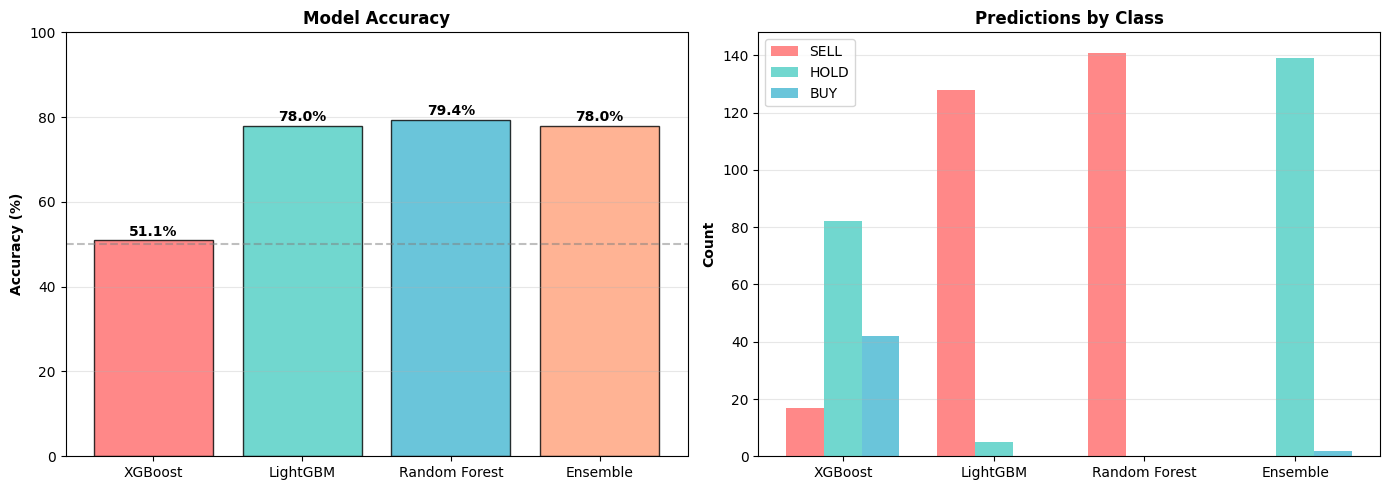

In [34]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
models = ['XGBoost', 'LightGBM', 'Random Forest', 'Ensemble']
accuracies = [xgb_accuracy, lgb_accuracy, rf_accuracy, ensemble_accuracy]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
bars = axes[0].bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_ylabel('Accuracy (%)', fontweight='bold')
axes[0].set_title('Model Accuracy', fontweight='bold')
axes[0].set_ylim(0, 100)
axes[0].axhline(50, color='gray', linestyle='--', alpha=0.5)
for bar, acc in zip(bars, accuracies):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{acc:.1f}%', ha='center', fontweight='bold', fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# Prediction counts
sell = [(predictions_calibrated == -1).sum(), (lgb_pred == 0).sum(), 
        (rf_pred == 0).sum(), (ensemble_pred == -1).sum()]
hold = [(predictions_calibrated == 0).sum(), (lgb_pred == 1).sum(), 
        (rf_pred == 1).sum(), (ensemble_pred == 0).sum()]
buy = [(predictions_calibrated == 1).sum(), (lgb_pred == 2).sum(), 
       (rf_pred == 2).sum(), (ensemble_pred == 1).sum()]

x = np.arange(len(models))
width = 0.25
axes[1].bar(x - width, sell, width, label='SELL', color='#FF6B6B', alpha=0.8)
axes[1].bar(x, hold, width, label='HOLD', color='#4ECDC4', alpha=0.8)
axes[1].bar(x + width, buy, width, label='BUY', color='#45B7D1', alpha=0.8)
axes[1].set_ylabel('Count', fontweight='bold')
axes[1].set_title('Predictions by Class', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
model_comparison_chart = Path.cwd().parent / 'data' / 'model_comparison.png'
plt.savefig(model_comparison_chart, dpi=150, bbox_inches='tight')
plt.show()